In [17]:
import sys
import math
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
from PIL import Image, ImageDraw
import torch

from tqdm import tqdm

import seaborn as sns
import pickle

import cv2

#from skimage.draw import ellipse
from skimage.measure import label, regionprops, find_contours, approximate_polygon
from skimage.transform import rotate
from sklearn.neighbors import KDTree
from scipy.spatial import distance


In [18]:
class cell_object:
    #Cell object - takes in a segmentation output and initializes a cell-object with notable properties calculated
    #
    
    def __init__(self, pred_box, polygon, score):
        self.boundingbox = pred_box
        
        if len(polygon) == 1:
            self.polygon = polygon[0]
        else:
            self.polygon = max(polygon, key = len)
        self.score = score
        
        
            
        
        self.mask = self.construct_b_mask(self.polygon,self.boundingbox)
        self.perimeter = self.calc_perimeter(self.polygon)
        
        self.centroid = self.calc_centroid(self.boundingbox)
        
        region_props = self.cell_poly_properties(self.mask)
        
        self.area = region_props[0]
        self.orientation = region_props[1]
        self.majaxis = region_props[2]
        self.minaxis = region_props[3]
        self.circularity = self.calc_circularity(self.area,self.perimeter)
        
    def construct_b_mask(self, polygon, bbox):
        buffer = 5
        width = int(abs(bbox[0]-bbox[2]))+2*buffer
        height = int(abs(bbox[1]-bbox[3]))+2*buffer
        result = np.copy(polygon)
        result[0::2] = np.subtract(result[0::2], min(result[0::2])-buffer)
        result[1::2] = np.subtract(result[1::2], min(result[1::2])-buffer)
        
        img = Image.new('1', (width, height), 0)
        img1 = ImageDraw.Draw(img)
        img1.polygon(result.tolist(), fill = 1, outline = 1)
        return np.array(img)
    
    def calc_centroid(self, bbox):
        return (((bbox[0]+bbox[2])/2).item() , ((bbox[1]+bbox[3])/2).item())
        
    def calc_perimeter(self, polygon):
        perimeter = 0
        for i in range (0,len(polygon)-4,2):
            perimeter += math.sqrt((polygon[i]-polygon[i+2])**2 + (polygon[i+1]-polygon[i+3])**2)
        perimeter += math.sqrt((polygon[0]-polygon[len(polygon)-2])**2 + (polygon[1]-polygon[len(polygon)-1])**2)
        return perimeter
    
    def cell_poly_properties(self, img):
        #takes in an array of a binary mask
        #finds notable cell properties
        #returns a cell array of user defined objects

        img = label(img)
        regions = regionprops(img)
        #print(regions[0].perimeter)
        
        cell_properties = (regions[0].area, regions[0].orientation, regions[0].major_axis_length, 
                           regions[0].minor_axis_length)

        return cell_properties
    
    def calc_circularity(self, area, perimeter):
        return (area * 4 * math.pi / (perimeter**2))
    
    def pickle_object(self):
        #pickle whole object
        return 0
    

In [26]:
#Class object for Lineage Data:
'''
For one cell lineage over multiple passages
contains in level:
cell lineage - tag
list of passages
list of days
list of cell objects

'''

class lineage:
    #lineage: reads in data from instances arranged in file tree as:
        #passages
            #days
                #instances - read in and intialize network_object
                #images(optional)
    
    
    def __init__(self, filepath, tag):
        
        self.tag = tag
        
        self.items = self.read_in(filepath)
        
    def read_in(self, filepath):
        result = []
        for passage_path in sorted(glob.glob(filepath+'/*/')):
            print(passage_path)
            days = []
            for day_path in sorted(glob.glob(passage_path+'*/')):
                print(day_path)
                cells = []
                for instance_path in sorted(glob.glob(day_path+'*.data')):
                    instances = {}
                    with open(instance_path, 'rb') as filehandle:
                        instances = pickle.load(filehandle)
                    print(instance_path)
                    for i in range(len(instances['pred_boxes'])):
                        cells.append(cell_object(instances['pred_boxes'][i],
                                                 instances['pred_masks'][i],
                                                 instances['scores'][i]))

                days.append(cells)
            result.append(days)
        return result
    

    def pickle_object(self):
        #pickle the whole object
        return 0

In [51]:
line_H = lineage('/home/trevor/Documents/Osmotic_trees/HYPER','hyper_tree')
line_R = lineage('/home/trevor/Documents/Osmotic_trees/ISO','iso_tree')
line_L = lineage('/home/trevor/Documents/Osmotic_trees/HYPO','hypo_tree')

/home/trevor/Documents/Osmotic_trees/HYPER/p1/
/home/trevor/Documents/Osmotic_trees/HYPER/p1/d1/
/home/trevor/Documents/Osmotic_trees/HYPER/p1/d1/instances367.data
/home/trevor/Documents/Osmotic_trees/HYPER/p1/d1/instances369.data
/home/trevor/Documents/Osmotic_trees/HYPER/p1/d1/instances373.data
/home/trevor/Documents/Osmotic_trees/HYPER/p1/d1/instances375.data
/home/trevor/Documents/Osmotic_trees/HYPER/p1/d1/instances376.data
/home/trevor/Documents/Osmotic_trees/HYPER/p1/d1/instances378.data
/home/trevor/Documents/Osmotic_trees/HYPER/p1/d1/instances382.data
/home/trevor/Documents/Osmotic_trees/HYPER/p1/d1/instances384.data
/home/trevor/Documents/Osmotic_trees/HYPER/p1/d2/
/home/trevor/Documents/Osmotic_trees/HYPER/p1/d3/
/home/trevor/Documents/Osmotic_trees/HYPER/p1/d4/
/home/trevor/Documents/Osmotic_trees/HYPER/p2/
/home/trevor/Documents/Osmotic_trees/HYPER/p2/d1/
/home/trevor/Documents/Osmotic_trees/HYPER/p2/d2/
/home/trevor/Documents/Osmotic_trees/HYPER/p2/d3/
/home/trevor/Documen

In [50]:
area_H = []
circularity_H = []
aspectr_H = []

area = []
circularity = []
aspectr = []

for pnum in line_H.items:
    
    temp_area = []
    temp_circularity = []
    temp_aspectr = []
    for dnum in pnum:
        for cell in dnum:
            temp_area.append(cell.area)
            temp_circularity.append(cell.circularity)
            temp_aspectr.append(cell.majaxis/cell.minaxis)
    area.append(temp_area)
    circularity.append(temp_circularity)
    aspectr.append(temp_aspectr)

area_H = area
circularity_H = circularity


NameError: name 'line_H' is not defined

In [49]:
len(area_7[4])

2014

In [ ]:
#load model output into instances dict: 
instances = {}
with open('instances335.data', 'rb') as filehandle:
#with open('instances.data', 'rb') as filehandle:
    instances = pickle.load(filehandle)
    
'''   "pred_boxes" "pred_masks" "scores" "classes"  "image_size" '''

In [ ]:
bounding_boxes = np.array(instances['pred_boxes'])
polygons = np.array(instances['pred_masks'])

In [529]:
#RUN ONCE FOR EACH DISCREET SAMPLE
cell_list = []

In [537]:
#cell_list = []
for i in range(len(instances['pred_boxes'])):
    cell_list.append(cell_object(instances['pred_boxes'][i],instances['pred_masks'][i],instances['scores'][i]))
print(len(instances['pred_boxes']))
print(len(cell_list))

63
190


In [ ]:
#RUN ONCE
full_list = []

In [538]:
#RUN ONCE FOR EACH DESCREET SAMPLE, AFTER CELL_LIST IS COMPLETE
full_list.append(np.array(np.copy(cell_list)))
print(len(instances['pred_boxes']))
print(len(full_list))

63
3


In [505]:
full_list[0][0].perimeter

85.6690475583121

In [ ]:
#PLOT AREA

areas = [[cell.area for cell in cell_list] for cell_list in full_list]

circularities = [[cell.circularity for cell in cell_list] for cell_list in full_list]

major_axes = [[cell.majaxis for cell in cell_list] for cell_list in full_list]

min_axes = [[cell.minaxis for cell in cell_list] for cell_list in full_list]

In [ ]:

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))

bp=ax1.boxplot(areas, notch = True)

bp=ax2.boxplot(circularities)

bp=ax3.boxplot(major_axes)

bp=ax4.boxplot(min_axes)

#   Hyper, Hypo, Iso

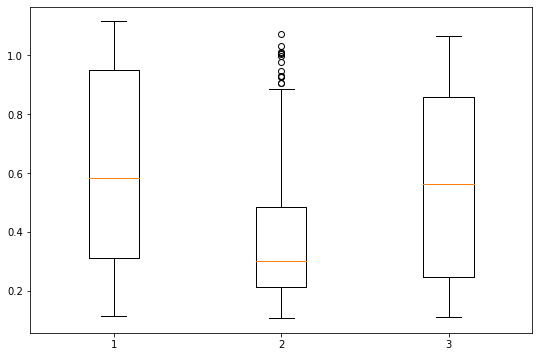

In [584]:
fig=plt.figure(1,figsize=(9,6))
ax2=fig.add_subplot(111)
bp=ax2.boxplot(circularities)

#   Hyper, Hypo, Iso

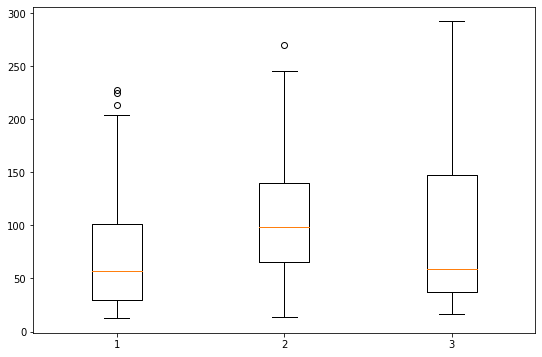

In [585]:
fig=plt.figure(1,figsize=(9,6))
ax2=fig.add_subplot(111)
bp=ax2.boxplot(major_axes)

#   Hyper, Hypo, Iso

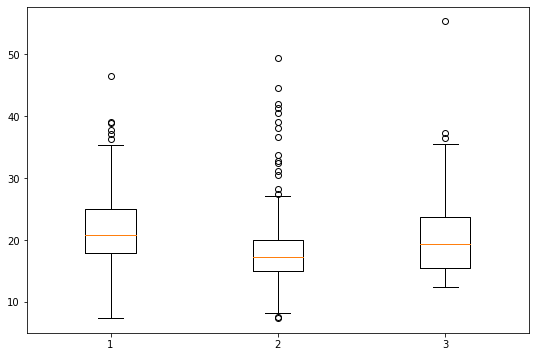

In [586]:
fig=plt.figure(1,figsize=(9,6))
ax2=fig.add_subplot(111)
bp=ax2.boxplot(min_axes)

#   Hyper, Hypo, Iso

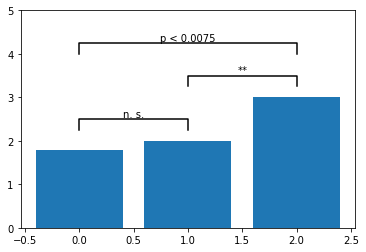

In [514]:
heights = [1.8, 2, 3]
bars = np.arange(len(heights))

plt.figure()
plt.bar(bars, heights, align='center')
plt.ylim(0, 5)
barplot_annotate_brackets(0, 1, .1, bars, heights)
barplot_annotate_brackets(1, 2, .001, bars, heights)
barplot_annotate_brackets(0, 2, 'p < 0.0075', bars, heights, dh=.2)

In [513]:
def barplot_annotate_brackets(num1, num2, data, center, height, yerr=None, dh=.05, barh=.05, fs=None, maxasterix=None):
    """ 
    Annotate barplot with p-values.

    :param num1: number of left bar to put bracket over
    :param num2: number of right bar to put bracket over
    :param data: string to write or number for generating asterixes
    :param center: centers of all bars (like plt.bar() input)
    :param height: heights of all bars (like plt.bar() input)
    :param yerr: yerrs of all bars (like plt.bar() input)
    :param dh: height offset over bar / bar + yerr in axes coordinates (0 to 1)
    :param barh: bar height in axes coordinates (0 to 1)
    :param fs: font size
    :param maxasterix: maximum number of asterixes to write (for very small p-values)
    """

    if type(data) is str:
        text = data
    else:
        # * is p < 0.05
        # ** is p < 0.005
        # *** is p < 0.0005
        # etc.
        text = ''
        p = .05

        while data < p:
            text += '*'
            p /= 10.

            if maxasterix and len(text) == maxasterix:
                break

        if len(text) == 0:
            text = 'n. s.'

    lx, ly = center[num1], height[num1]
    rx, ry = center[num2], height[num2]

    if yerr:
        ly += yerr[num1]
        ry += yerr[num2]

    ax_y0, ax_y1 = plt.gca().get_ylim()
    dh *= (ax_y1 - ax_y0)
    barh *= (ax_y1 - ax_y0)

    y = max(ly, ry) + dh

    barx = [lx, lx, rx, rx]
    bary = [y, y+barh, y+barh, y]
    mid = ((lx+rx)/2, y+barh)

    plt.plot(barx, bary, c='black')

    kwargs = dict(ha='center', va='bottom')
    if fs is not None:
        kwargs['fontsize'] = fs

    plt.text(*mid, text, **kwargs)

In [455]:
#calculate all masks
bounding_boxes = np.array(instances['pred_boxes'])
polygons = np.array(instances['pred_masks'])

#masks = []
#^Run cell above

buffer = 5
for i in range(len(bounding_boxes)):
    width = int(abs(bounding_boxes[i][0]-bounding_boxes[i][2]))+2*buffer
    height = int(abs(bounding_boxes[i][1]-bounding_boxes[i][3]))+2*buffer
    polygon = np.copy(polygons[i])
    polygon[0][0::2] = np.subtract(polygon[0][0::2], min(polygon[0][0::2])-buffer)
    polygon[0][1::2] = np.subtract(polygon[0][1::2], min(polygon[0][1::2])-buffer)
    #print(i,min(polygon[0][0::2].tolist()),polygon[0][0::2])
    
    
    img = Image.new('1', (width, height), 0)
    img1 = ImageDraw.Draw(img)
    img1.polygon(polygon[0].tolist(), fill = 1, outline = 1)
    #ImageDraw.Draw(img).polygon(polygon[0], outline=1, fill=1)
    masks.append(np.array(img))
    

343
304


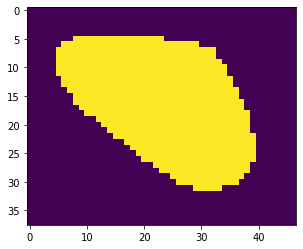

In [581]:
#print(masks[0])
print(len(masks))
import random
index = int(random.random()*len(masks))
print(index)
plt.imshow(masks[index])

In [543]:
np.array(instances['pred_boxes'][0])

array([ 684.72437, 1161.0521 ,  716.3465 , 1192.3954 ], dtype=float32)

In [244]:
from skimage.measure import label, regionprops, find_contours, approximate_polygon


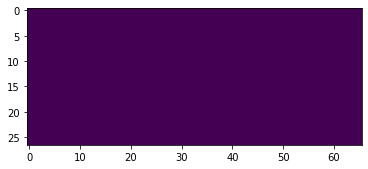

In [382]:
a = 379

plt.imshow(masks[379])

#newcell = cell_object(instances['pred_boxes'][a],instances['pred_masks'][a][0],instances['scores'][a])

In [354]:
newcell = cell_object(instances['pred_boxes'][0],instances['pred_masks'][0][0],instances['scores'][0])

In [396]:
#cell_list = [cell_object(instances['pred_boxes'][i],instances['pred_masks'][i][0],instances['scores'][i]) 
#             for i in range(len(instances['pred_boxes']))]

cell_list = []
for i in range(len(instances['pred_boxes'])):
    cell_list.append(cell_object(instances['pred_boxes'][i],instances['pred_masks'][i],instances['scores'][i]))


In [398]:
len(cell_list)

446